In [1]:
%pylab inline

from PyTools import err, binner, nbins, binned_stat
from sklearn.cluster import DBSCAN
from scipy.optimize import leastsq
from string import join
from scipy.ndimage.filters import gaussian_filter
import paper_style, os

Populating the interactive namespace from numpy and matplotlib


In [2]:
write_tables_for_fig4 = False

def put_FITS_names(table):
    descr = table.dtype.descr
    for i in xrange(3): descr.pop(0)
    descr = [("input_file", "|S25")] + descr

    new_table = zeros(table.shape[0], dtype=descr)
    new_table["input_file"] = ["spSpec-{0:05d}-{1:04d}-{2:03d}.fit".format(r["mjd"], r["plate"], r["fiberID"])
                               for r in table]
    for f in new_table.dtype.names[1:]:
        new_table[f] = table[f]
    
    return new_table

par_lbs = [r"$M_\star$", r"$\left<\log{t_\star}\right>_M$", r"$\left<\log{t_\star}\right>_L$",
           r"$\left<\log{Z_\star/Z\odot}\right>_M$", r"$\left<\log{Z_\star/Z\odot}\right>_L$", r"$A_V$"]

if "paper_style" in dir():
    mnorm = 1e9
    od = os.path.expandvars("$HOME/Documents/Publications/photofit_near_paper/")
    par_lbs = [r"$\log{M_\star/M\odot}$", r"$\left<\log{t_\star}\right>_M$", r"$\left<\log{t_\star}\right>_L$",
               r"$\left<\log{Z_\star/Z\odot}\right>_M$", r"$\left<\log{Z_\star/Z\odot}\right>_L$", r"$A_V$",
               r"$A_V$", r"$z$"]
    res_lbs = [r"$\Delta\log{M_\star}$", r"$\Delta\left<\log{t_\star}\right>_M$",
               r"$\Delta\left<\log{t_\star}\right>_L$", r"$\Delta\left<\log{Z_\star}\right>_M$",
               r"$\Delta\left<\log{Z_\star}\right>_L$", r"$\Delta A_V$"]
    hatching = "/"*15
    gray = "0.3"
    ssag_cl = "0.2"
    sdss_cl = "#F6C141"
    sdss_sg = [sdss_cl, "#E8601C"]
    jpas_cl = "#90C987"
    jpas_sg = [jpas_cl, "#4EB265"]
    spec_cl = "#7BAFDE"
    spec_sg = [spec_cl, "#1965B0"]
    map_col = cm.viridis
else:
    mnorm = 1e8
    od = "img/"
    par_lbs = ["Mass (log/M$\odot$)", "Age (log/yr)", "Age (log/yr)", "Metallicity (log/Z$\odot$)",
               "Metallicity (log/Z$\odot$)", "Dust Extinction (mag)", "Redshift"]

In [3]:
#READ TABLES

emission_detections = loadtxt("../inputs/real_deal7/jpas_residual_emission.txt", dtype=str)
Lfrac = put_FITS_names(genfromtxt("data/RealDeal/lumfrac.txt", dtype=None, names=True))
SN = genfromtxt("data/RealDeal/snr.txt", dtype=None, names=True)
Cind = put_FITS_names(genfromtxt("data/RealDeal/conIndex_test.txt", dtype=None, names=True))
u_lib, g_lib, r_lib, i_lib, z_lib = loadtxt("../inputs/set3_catalog.txt", usecols=range(39, 39 + 5), unpack=True)
age_lib, met_lib = loadtxt("../inputs/set3+red.log", usecols=(26, 7), unpack=True)
u_mil, g_mil, r_mil, i_mil, z_mil = loadtxt("data/RealDeal/1ABmag.txt", usecols=range(1, 1 + 5), unpack=True)
catalog = genfromtxt("data/RealDeal/catalog.txt", dtype=None, names=True)
gal2005 = genfromtxt("data/RealDeal/gal2005.txt", dtype=None, names=True)
galtab2 = array([[ 8.91, -0.60, -1.11, -0.00, 9.06, 8.80,  9.46],
                 [ 9.11, -0.61, -1.07, -0.00, 9.09, 8.81,  9.48],
                 [ 9.31, -0.65, -1.10, -0.05, 9.11, 8.85,  9.44],
                 [ 9.51, -0.61, -1.03, -0.01, 9.17, 8.89,  9.49],
                 [ 9.72, -0.52, -0.97,  0.05, 9.23, 8.94,  9.57],
                 [ 9.91, -0.41, -0.90,  0.09, 9.32, 9.00,  9.71],
                 [10.11, -0.23, -0.80,  0.14, 9.46, 9.09,  9.85],
                 [10.31, -0.11, -0.65,  0.17, 9.61, 9.23,  9.93],
                 [10.51, -0.01, -0.41,  0.20, 9.73, 9.34,  9.98],
                 [10.72,  0.04, -0.24,  0.22, 9.82, 9.48, 10.03],
                 [10.91,  0.07, -0.14,  0.24, 9.87, 9.60, 10.06],
                 [11.11,  0.10, -0.09,  0.25, 9.90, 9.67, 10.08],
                 [11.31,  0.12, -0.06,  0.26, 9.92, 9.72, 10.09],
                 [11.51,  0.13, -0.04,  0.28, 9.94, 9.75, 10.11],
                 [11.72,  0.14, -0.03,  0.29, 9.95, 9.76, 10.12],
                 [11.91,  0.15, -0.03,  0.30, 9.96, 9.77, 10.12]])

spec_ne = genfromtxt(os.path.expandvars("$master/inputs/real_deal7/outs/spec/")+"dynbas_output.log", dtype=None,
                     names=True)
spec_ne["input_file"] = array(["spSpec"+name.lstrip("dynbasfit_processed_SPEC_").replace(".log", ".fit")
                               for name in spec_ne["input_file"]])
spec_ne["M_mod"] = log10(spec_ne["M_mod"])

jpas_ne = genfromtxt(os.path.expandvars("$master/inputs/real_deal7/outs/nem_jpas/")+"dynbas_output.log",
                     dtype=None, names=True)
jpas_ne["input_file"] = array(["spSpec"+name.lstrip("dynbasfit_processed_nem_JPAS_").replace(".log", ".fit")
                               for name in jpas_ne["input_file"]])
jpas_ne["M_mod"] = log10(jpas_ne["M_mod"])

#sdss_ne = genfromtxt(os.path.expandvars("$master/inputs/real_deal7/outs/sdss/")+"dynbas_output.log",
#                     dtype=None, names=True)
#sdss_ne["input_file"] = array(["spSpec"+name.lstrip("dynbasfit_processed_SDSS_").replace(".log", ".fit")
#                               for name in sdss_ne["input_file"]])
#sdss_ne["M_mod"] = log10(sdss_ne["M_mod"])

name_spec = loadtxt("../outputs/spectroscopic_fit/names_v3s20m.txt", usecols=(0,), dtype=str)
name_jpas = loadtxt("../inputs/photoz3/set3.equiv", dtype=str, usecols=(2,))[:120].repeat(50, axis=0)
name_jpas = array([name+".fits.gz" for name in name_jpas], dtype=str)
sort_spec = argsort(name_spec)
sort_jpas = argsort(name_jpas)

jpas_tta = genfromtxt("../outputs/photometric_fit/photoz3/corr_photofit_z0p00.physical",
                           usecols=range(1, 1+12, 2), dtype=None, names=True)[:6000][sort_jpas]
spec_tta = genfromtxt("../outputs/spectroscopic_fit/dynbas_table_v3s20m.txt",
                           usecols=range(6), dtype=None, names=True)[sort_spec]

jpas_tta["Z_M_mod"], jpas_tta["Z_L_mod"] = log10(jpas_tta["Z_M_mod"]), log10(jpas_tta["Z_L_mod"])
jpas_tta.dtype.names = spec_tta.dtype.names
                                                           
parr = array([-1.69252953, -0.4964394,   9.35303768])
pard = array([ 0.04363491, -0.23994185,  9.56363449])
par0 = array([ 0.32472905, -0.39032184,  9.70852055])
x = linspace(8.0, 10.2)
y = linspace(-0.7, 0.4)

In [4]:
#COMMON MASKS
in_spec_ne = array([galaxy in spec_ne["input_file"] for galaxy in catalog["input_file"]], dtype=bool)
in_jpas_ne = array([galaxy in jpas_ne["input_file"] for galaxy in catalog["input_file"]], dtype=bool)
in_gal2005 = array([galaxy in gal2005["input_file"] for galaxy in catalog["input_file"]], dtype=bool)
g05_in_sam = array([galaxy in spec_ne["input_file"] for galaxy in gal2005["input_file"]], dtype=bool)
sam_in_g05 = array([galaxy in gal2005["input_file"] for galaxy in spec_ne["input_file"]], dtype=bool)
nem_detect = ~array([galaxy in emission_detections for galaxy in spec_ne["input_file"]], dtype=bool)

col = (catalog["u_mag"] - catalog["r_mag"])[in_spec_ne]
snr = SN[in_spec_ne]

#SAMPLE DEFINITION MASKS
# mask for g05 subsamples
SF_hSNR_g05_mask = (sam_in_g05)&(col< 2.22)&(snr["snr_wall"]>15.0)
SF_hSNR_m16_mask = (~sam_in_g05)&(col< 2.22)&(snr["snr_wall"]>15.0)
Pa_hSNR_g05_mask = (sam_in_g05)&(col>=2.22)&(snr["snr_wall"]>15.0)
# mask for cat subsamples
SF_lSNR_m16_mask = (~sam_in_g05)&(col< 2.22)&(snr["snr_wall"]<=15.0)
Pa_lSNR_m16_mask = (~sam_in_g05)&(col>=2.22)&(snr["snr_wall"]<=15.0)

In [5]:
print "SF_hSNR_g05:", SF_hSNR_g05_mask.sum()
print "SF_hSNR_m16:", SF_hSNR_m16_mask.sum()
print "Pa_hSNR_g05:", Pa_hSNR_g05_mask.sum()
print "SF_lSNR_m16:", SF_lSNR_m16_mask.sum()
print "Pa_lSNR_m16:", Pa_lSNR_m16_mask.sum()
print
print "Total      :", SF_hSNR_g05_mask.sum()+SF_hSNR_m16_mask.sum()+Pa_hSNR_g05_mask.sum()+SF_lSNR_m16_mask.sum()+\
                      Pa_lSNR_m16_mask.sum()

SF_hSNR_g05: 3575
SF_hSNR_m16: 1719
Pa_hSNR_g05: 5887
SF_lSNR_m16: 1608
Pa_lSNR_m16: 144

Total      : 12933


In [6]:
#COMMON QUANTITIES

colors = ["#114477", "#117733", "#771122"]

cat = catalog[in_spec_ne]
lfr = Lfrac[in_spec_ne]
con = (Cind["petroR90_r"][in_spec_ne]/Cind["petroR50_r"][in_spec_ne])
rat = 3./Cind["petroR90_r"][in_spec_ne]
col = cat["u_mag"] - cat["r_mag"]

sfgal = col< 2.22
pagal = col>=2.22

/home/mejia/Programs/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide
/home/mejia/Programs/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide


In [7]:
print "tables match?", all(spec_ne["input_file"]==cat["input_file"])&all(cat["input_file"]==lfr["input_file"])&\
                       all(cat["input_file"]==Cind["input_file"][in_spec_ne])

tables match? True


In [16]:
if write_tables_for_fig4:
    mask = nem_detect&(snr["snr_CaII"]>=5.0)&(spec_ne["log_t_L_mod"]>8)&(jpas_ne["log_t_L_mod"]>8)
    print sfgal[mask].sum()
    savetxt("data/PhotoNearAnalysis/ur_color.txt", col[mask])
    for i, field in enumerate(spec_ne.dtype.names):
        if i in [2,3,4,5,6,7]:
            savetxt("data/PhotoNearAnalysis/{0}.txt".format(field), jpas_ne[mask][field]-spec_ne[mask][field])
            print "data/PhotoNearAnalysis/{0}.txt".format(field)
            figure()
            gca().set_title(field.replace(r"_", r"\_"))
            xo, yo, eo = binner(col[mask], jpas_ne[mask][field]-spec_ne[mask][field], "median", 5, rang=(1.3, 3), ebar=True)
            plot(yo, xo, "-", color=gray, lw=1.5, label=r"\bf Real galaxies")
            plot(yo-eo[0], xo, "-", color=gray, lw=0.5)
            plot(yo+eo[1], xo, "-", color=gray, lw=0.5)
            axvline(ls=":", color="k")
            axhline(2.22, ls=":", color="k")
            xlim(-0.7,0.7)
            #hist((jpas_ne[mask][field]-spec_ne[mask][field]), 20, range=[-0.7,0.7], histtype="step", hatch="///", lw=0)
    print "tables written"

In [9]:
m_p, t_p = binner(spec_ne["M_mod"][pagal], spec_ne["log_t_L_mod"][pagal], "median", 16, rang=(8.8, 12))
m_p, z_p = binner(spec_ne["M_mod"][pagal], spec_ne["log_Z_L_mod"][pagal], "median", 16, rang=(8.8, 12))

m_f, t_f = binner(spec_ne["M_mod"][sfgal], spec_ne["log_t_L_mod"][sfgal], "median", 16, rang=(8.8, 12))
m_f, z_f = binner(spec_ne["M_mod"][sfgal], spec_ne["log_Z_L_mod"][sfgal], "median", 16, rang=(8.8, 12))

print "mean offset for PaGs:", mean((t_p-galtab2[:, 4])[~isnan(t_p)]), mean((z_p-galtab2[:, 1])[~isnan(z_p)])
print "mean offset for SFGs:", mean((t_f-galtab2[:, 4])[~isnan(t_f)]), mean((z_f-galtab2[:, 1])[~isnan(z_f)])

mean offset for PaGs: -0.259954545455 0.194727272727
mean offset for SFGs: -0.617269230769 -0.151192307692


/home/mejia/Programs/miniconda2/lib/python2.7/site-packages/numpy/ma/core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


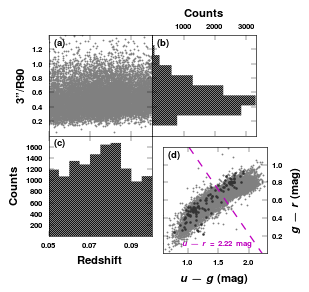

In [10]:
fig = figure(figsize=(2.5, 2.5))

gs1 = matplotlib.gridspec.GridSpec(2, 2, hspace=0, wspace=0, left=0, top=1)
ax00 = fig.add_subplot(gs1[0, 0], xticklabels=[])
ax01 = fig.add_subplot(gs1[0, 1])
ax10 = fig.add_subplot(gs1[1, 0])

ax01.tick_params(labelleft=False, labelbottom=False, labeltop=True)
ax01.xaxis.set_label_position("top")

gs2 = matplotlib.gridspec.GridSpec(2, 2, hspace=0.05, wspace=0.1, left=0, top=1, right=0.95, bottom=0.05)
ax11 = fig.add_subplot(gs2[1, 1])

ax11.tick_params(labelleft=False, labelright=True)
ax11.yaxis.set_label_position("right")

axs = array([[ax00, ax01], [ax10, ax11]])
# ---------------------------------------------------------------------------
axs[0, 0].text(0.05, 0.90, r"\bf (a)", fontsize="small", ha="left", transform=axs[0, 0].transAxes)
axs[0, 0].set_xticks(arange(0.05, 0.11, 0.02))
axs[0, 0].set_xlim(0.05, 0.1)
axs[0, 0].set_ylim(0.00, 1.4)
axs[0, 0].set_ylabel(r'\bf 3"/R90')
axs[0, 0].scatter(cat["redshift"], rat, lw=0, c="0.5", s=2)
# ---------------------------------------------------------------------------
axs[0, 1].text(0.05, 0.90, r"\bf (b)", fontsize="small", ha="left", transform=axs[0, 1].transAxes)
axs[0, 1].set_xticks([0, 1000, 2000, 3000, 3500])
rg = axs[0, 1].set_ylim(0.00, 1.4)
axs[0, 1].set_xlabel(r"\bf Counts")
axs[0, 1].hist(rat, 10, histtype="stepfilled", hatch=4*"///", lw=0, fc="none", color="0.5", range=rg,
               orientation="horizontal")
# ---------------------------------------------------------------------------
axs[1, 0].text(0.05, 0.90, r"\bf (c)", fontsize="small", ha="left", transform=axs[1, 0].transAxes)
axs[1, 0].set_xticks(arange(0.05, 0.11, 0.02))
rg = axs[1, 0].set_xlim(0.05, 0.1)
axs[1, 0].set_xlabel(r'\bf Redshift')
axs[1, 0].set_ylabel(r"\bf Counts")
axs[1, 0].hist(cat["redshift"], 10, histtype="stepfilled", hatch=4*"///", lw=0, fc="none", color="0.5", range=rg)
# ---------------------------------------------------------------------------
xl, yl = array(axs[1, 1].set_xlim(0.6, 2.3)), array(axs[1, 1].set_ylim(0.0, 1.2))
axs[1, 1].text(0.05, 0.90, r"\bf (d)", fontsize="small", ha="left", transform=axs[1, 1].transAxes)
axs[1, 1].set_xlabel(r"\bf $u-g$ (mag)")
axs[1, 1].set_ylabel(r"\bf $g-r$ (mag)")
axs[1, 1].scatter(cat["u_mag"]-cat["g_mag"], cat["g_mag"]-cat["r_mag"], lw=0, c="0.5", s=2)
axs[1, 1].scatter(u_lib-g_lib, g_lib-r_lib, lw=0, c="0.2", s=4)
axs[1, 1].plot(xl, 2.22-xl, "--", color="m")
axs[1, 1].text(0.85, 0.08, r"\bf $u-r=2.22\,$mag", ha="right", fontsize="x-small", color="m",
               transform=axs[1, 1].transAxes)
# ---------------------------------------------------------------------------

for ax in axs.ravel():
    if not ax.is_first_col():
        ax.set_xticks(ax.get_xticks()[1:-1])
    ax.set_yticks(ax.get_yticks()[1:-1])

savefig(od + "sample_chars")

/home/mejia/Programs/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log10
/home/mejia/Programs/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in log10
/home/mejia/Programs/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in log10
/home/mejia/Programs/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in log10


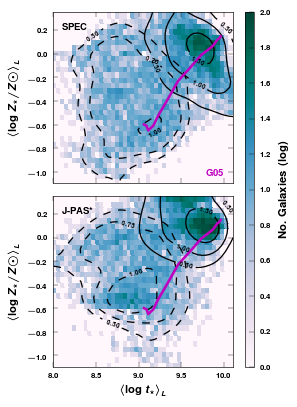

In [24]:
#config figure and axes

#fig, axs = subplots(2, 1, figsize=(3.3, 4.5), sharex=True, sharey=True)

fig = figure(figsize=(3.3, 4.5))

ax1 = subplot2grid((2, 10), (0, 0), colspan=9, xticklabels=[])
ax2 = subplot2grid((2, 10), (1, 0), colspan=9)
axc = subplot2grid((2, 10), (0, 9), rowspan=2)
axs = array([ax1, ax2])

rx = xlim(8.0, 10.15)
ry = ylim(-1.1, 0.4)
axs[1].set_xlabel(par_lbs[2])
axs[0].set_ylabel(par_lbs[4])
axs[1].set_ylabel(par_lbs[4])
axs[0].text(0.05, 0.9, r"\bf SPEC", fontsize="small", ha="left", transform=axs[0].transAxes)
axs[1].text(0.05, 0.9, r"\bf J-PAS*", fontsize="small", ha="left", transform=axs[1].transAxes)

#define binning and space using SPEC results
SNR = False

#mask = snr["snr_wall"]>-1        # no mask
#mask = nem_detect                # mask residual emission
#SNR, WL = 25, "Zfea"
#mask = (snr["snr_"+WL]>SN)       # mask by SNR
#mask = SF_hSNR_g05_mask|Pa_hSNR_g05_mask
#mask = SF_hSNR_m16_mask|SF_lSNR_m16_mask|Pa_lSNR_m16_mask
#mask = sam_in_g05&nem_detect&(jpas_ne["log_t_L_mod"]>8.0)
mask = nem_detect&(snr["snr_CaII"]>=5.0)&(spec_ne["log_t_L_mod"]>8)&(jpas_ne["log_t_L_mod"]>8)

nx, xi, xf, bsx = nbins(spec_ne["log_t_L_mod"])
ny, yi, yf, bsy = nbins(spec_ne["log_Z_L_mod"])

#build SPEC histograms
H_sf, xe, ye = histogram2d(spec_ne["log_t_L_mod"][sfgal&mask], spec_ne["log_Z_L_mod"][sfgal&mask],
                           bins=[nx, ny], range=[rx, ry])
H_pa, xe, ye = histogram2d(spec_ne["log_t_L_mod"][pagal&mask], spec_ne["log_Z_L_mod"][pagal&mask],
                           bins=[nx, ny], range=[rx, ry])

H_al = H_sf + H_pa
img = axs[0].pcolormesh(xe[:- 1], ye[:- 1], log10(H_al).T, cmap=cm.PuBuGn, vmin=0, vmax=2, edgecolor="face")

#SF galaxies contours
H_sf = gaussian_filter(H_sf, sigma=2)
cont = axs[0].contour(xe[:- 1], ye[:- 1], log10(H_sf).T, [0.5, 0.75, 1], colors="k", linewidths=1, linestyles="--")
clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)

#passive galaxies contours
H_pa = gaussian_filter(H_pa, sigma=2)
cont = axs[0].contour(xe[:- 1], ye[:- 1], log10(H_pa).T, [0.5, 1, 1.5], colors="k", linewidths=1)
clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)

#------------------------------------------------------------------------------------------------------------

#build J-PAS histograms
H_sf, xe, ye = histogram2d(jpas_ne["log_t_L_mod"][sfgal&mask], jpas_ne["log_Z_L_mod"][sfgal&mask],
                           bins=[nx, ny], range=[rx, ry])
H_pa, xe, ye = histogram2d(jpas_ne["log_t_L_mod"][pagal&mask], jpas_ne["log_Z_L_mod"][pagal&mask],
                           bins=[nx, ny], range=[rx, ry])

H_al = H_sf + H_pa
img = axs[1].pcolormesh(xe[:- 1], ye[:- 1], log10(H_al).T, cmap=cm.PuBuGn, vmin=0, vmax=2, edgecolor="face")

#SF galaxies contours
H_sf = gaussian_filter(H_sf, sigma=2)
cont = axs[1].contour(xe[:- 1], ye[:- 1], log10(H_sf).T, [0.5, 0.75, 1], colors="k", linewidths=1, linestyles="--")
clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)

#passive galaxies contours
H_pa = gaussian_filter(H_pa, sigma=2)
cont = axs[1].contour(xe[:- 1], ye[:- 1], log10(H_pa).T, [0.5, 1, 1.5], colors="k", linewidths=1)
clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)

if any(mask!=sam_in_g05):
    axs[0].plot(galtab2[:, 4], galtab2[:, 1], "-", lw=2, color="m")
    axs[1].plot(galtab2[:, 4], galtab2[:, 1], "-", lw=2, color="m")
axs[0].text(0.9, 0.05, r"\bf G05", color="m", fontsize="small", ha="center", transform=axs[0].transAxes)

#axs[0].plot(spec_tta["log_t_L_mod"][::50], spec_tta["log_Z_L_mod"][::50], ".", color="#E71D36")
#axs[1].plot(jpas_tta["log_t_L_mod"][::50], jpas_tta["log_Z_L_mod"][::50], ".", color="#E71D36")

cb = colorbar(img, axc)
cb.set_label(r"\bf No. Galaxies (log)")

tight_layout()

if all(mask==nem_detect&(snr["snr_CaII"]>=5.0)&(spec_ne["log_t_L_mod"]>8)&(jpas_ne["log_t_L_mod"]>8)):
    savefig(od + "lw_AMR")
elif all(mask==nem_detect):
    axs[1].text(0.05, 0.05, r"\bf No emission", fontsize="small", ha="left", transform=axs[1].transAxes)
    savefig("img/lw_AMR_nem")
elif all(mask==sam_in_g05&nem_detect&(jpas_ne["log_t_L_mod"]>8.0)):
    H_ga, xe, ye = histogram2d(gal2005["log_t_L_mod"][g05_in_sam][sfgal[sam_in_g05]],
                               gal2005["log_Z_L_mod"][g05_in_sam][sfgal[sam_in_g05]],
                               bins=[nx, ny], range=[rx, ry])
    H_ga = gaussian_filter(H_ga, sigma=2)
    cont = axs[0].contour(xe[:- 1], ye[:- 1], log10(H_ga).T, [0.5, 0.75, 1], colors="m", linestyles="--")
    clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)
    
    H_ga, xe, ye = histogram2d(gal2005["log_t_L_mod"][g05_in_sam][pagal[sam_in_g05]],
                               gal2005["log_Z_L_mod"][g05_in_sam][pagal[sam_in_g05]],
                               bins=[nx, ny], range=[rx, ry])
    H_ga = gaussian_filter(H_ga, sigma=2)
    cont = axs[0].contour(xe[:- 1], ye[:- 1], log10(H_ga).T, [0.5, 1, 1.5], colors="m")
    clabel(cont, fontsize=5, fmt=r"\bf %.2f", inline=True)
    
    savefig("img/lw_AMR_G05_contours")
elif SNR:
    axs[1].text(0.05, 0.05, r"\bf SN$>${}@{}".format(SNR, WL), fontsize="small", ha="left",
                transform=axs[1].transAxes)
    savefig("img/lw_AMR_sn{}_{}".format(SNR, WL))
else:
    savefig("img/lw_AMR_test")

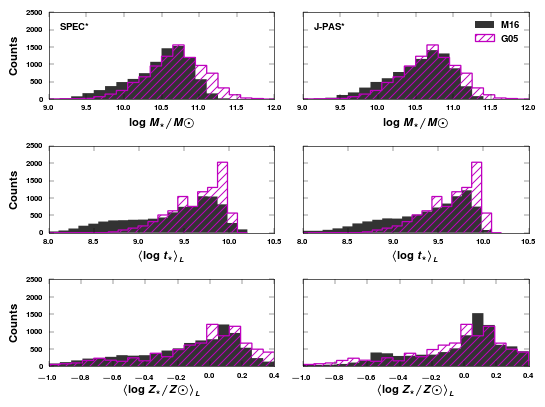

In [12]:
#kw, rg = "M_mod", [9, 12]
#kw, rg = "log_t_L_mod", [8,10.2]
#kw, rg = "log_Z_L_mod", [-1,0.4]

fig, axs = subplots(3, 2, figsize=(6, 4.5), sharex="row", sharey=True)

kws = "M_mod log_t_L_mod log_Z_L_mod".split()
ran = [[9, 12], [8, 10.2], [-1, 0.4]]
lbs = [par_lbs[0], par_lbs[2], par_lbs[4]]

axs[0, 0].text(0.05, 0.8, r"\bf SPEC*", fontsize="small", ha="left", transform=axs[0, 0].transAxes)
axs[0, 1].text(0.05, 0.8, r"\bf J-PAS*", fontsize="small", ha="left", transform=axs[0, 1].transAxes)

mask = (snr["snr_CaII"][sam_in_g05]>=5)
for i, (kw, rg, lb) in enumerate(zip(kws, ran, lbs)):
    axs[i, 0].hist(spec_ne[kw][sam_in_g05][mask], 20, range=rg, histtype="stepfilled", lw=0, color="0.2")
    axs[i, 1].hist(jpas_ne[kw][sam_in_g05][mask], 20, range=rg, histtype="stepfilled", lw=0, color="0.2",
                   label=r"\bf M16")
    axs[i, 0].hist(gal2005[kw][g05_in_sam][mask], 20, range=rg, histtype="step", ec="m", hatch="///")
    axs[i, 1].hist(gal2005[kw][g05_in_sam][mask], 20, range=rg, histtype="step", ec="m", hatch="///",
                   label=r"\bf G05")

    axs[i, 0].set_xlabel(lb)
    axs[i, 1].set_xlabel(lb)
    axs[i, 0].set_ylabel(r"\bf Counts")

axs[0, 1].legend(loc=0, fontsize="small")
fig.tight_layout()

savefig("img/pars_hist", bbox_inches="tight")

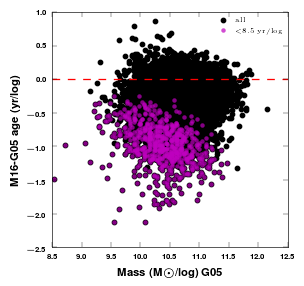

In [13]:
mask = (spec_ne["log_t_L_mod"][sam_in_g05]<8.5)
plot(gal2005["M_mod"][g05_in_sam],
     spec_ne["log_t_L_mod"][sam_in_g05]-gal2005["log_t_L_mod"][g05_in_sam], ".k", mew=1, label="all")
plot(gal2005["M_mod"][g05_in_sam][mask],
     spec_ne["log_t_L_mod"][sam_in_g05][mask]-gal2005["log_t_L_mod"][g05_in_sam][mask], ".m", alpha=0.7, label="<8.5 yr/log")
axhline(ls="--", color="r")

legend(loc=0)

xlabel(r"\bf Mass (M$\odot$/log) G05")
ylabel(r"\bf M16-G05 age (yr/log)")

savefig("img/G05_comp1", bbox_inches="tight")

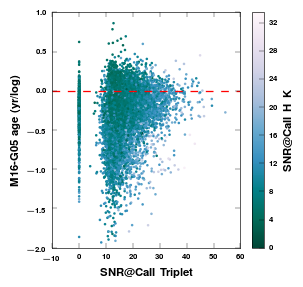

In [14]:
ylim(-2, +1)

mask = (spec_ne["log_t_L_mod"][sam_in_g05]<18.5)
scatter(snr["snr_CaII"][sam_in_g05][mask],
        spec_ne["log_t_L_mod"][sam_in_g05][mask]-gal2005["log_t_L_mod"][g05_in_sam][mask],
        c=snr["snr_CaHK"][sam_in_g05][mask], s=4, lw=0, cmap=cm.PuBuGn_r)
cb = colorbar()
axhline(ls="--", color="r")

xlabel(r"\bf SNR@CaII Triplet")
ylabel(r"\bf M16-G05 age (yr/log)")
cb.set_label(r"\bf SNR@CaII H & K")

savefig("img/G05_comp2", bbox_inches="tight")

In [15]:
res_t = spec_ne["log_t_L_mod"][sam_in_g05][mask]-gal2005["log_t_L_mod"][g05_in_sam][mask]
res_z = spec_ne["log_Z_L_mod"][sam_in_g05][mask]-gal2005["log_Z_L_mod"][g05_in_sam][mask]

isort = argsort(abs(res_t))
isort = isort[::-1]

print "AGES                   ", "METALLICITIES"
print "{0:>7s} {1:>7s} {2:>7s} {0:>7s} {1:>7s} {2:>7s}".format("M16-G05", "M16", "G05", "M16-G05", "M16", "G05")
for i in xrange(30):
    t_m16, t_g05 = spec_ne["log_t_L_mod"][sam_in_g05][mask][isort][i], gal2005["log_t_L_mod"][g05_in_sam][mask][isort][i]
    z_m16, z_g05 = spec_ne["log_Z_L_mod"][sam_in_g05][mask][isort][i], gal2005["log_Z_L_mod"][g05_in_sam][mask][isort][i]
    mjd, plate, fiber = map(int, spec_ne["input_file"][sam_in_g05][mask][isort][i].lstrip("spSpec-").rstrip(".fit").split("-"))
    print "{0:7.4f} {1:7.4f} {2:7.4f} {3:7.4f} {4:7.4f} {5:7.4f} http://skyserver.sdss.org/dr7/en/tools/explore/obj.asp?plate={7}&mjd={6}&fiber={8}".format(res_t[isort][i], t_m16, t_g05, res_z[isort][i], z_m16, z_g05, mjd, plate, fiber)

AGES                    METALLICITIES
M16-G05     M16     G05 M16-G05     M16     G05
-2.1292  7.7050  9.8342 -0.0361 -0.7710 -0.7349 http://skyserver.sdss.org/dr7/en/tools/explore/obj.asp?plate=374&mjd=51791&fiber=3
-2.1268  7.0200  9.1468  0.5592 -0.5450 -1.1042 http://skyserver.sdss.org/dr7/en/tools/explore/obj.asp?plate=463&mjd=51908&fiber=488
-1.9340  7.3240  9.2580  1.1941 -0.4610 -1.6551 http://skyserver.sdss.org/dr7/en/tools/explore/obj.asp?plate=279&mjd=51984&fiber=492
-1.9133  7.7770  9.6903  0.7832 -0.1770 -0.9602 http://skyserver.sdss.org/dr7/en/tools/explore/obj.asp?plate=439&mjd=51877&fiber=557
-1.8974  7.0730  8.9704  0.0987 -0.3670 -0.4657 http://skyserver.sdss.org/dr7/en/tools/explore/obj.asp?plate=1740&mjd=53050&fiber=24
-1.8644  7.2020  9.0664 -0.1514 -0.2540 -0.1026 http://skyserver.sdss.org/dr7/en/tools/explore/obj.asp?plate=327&mjd=52294&fiber=515
-1.8541  7.4520  9.3061  0.6261 -0.0900 -0.7161 http://skyserver.sdss.org/dr7/en/tools/explore/obj.asp?plate=433&mjd=5